<a href="https://colab.research.google.com/github/DavoodSZ1993/Dive_into_Deep_Learning/blob/main/10_1_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install d2l==1.0.0-alpha1.post0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 KB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.9 MB/s eta 0:00:00


## 10.1 Long Short-Term Memory (LSTM)

### 10.1.2 Implementation from Scratch

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

#### Initializing Model Parameters

In [3]:
class LSTMScratch(d2l.Module):
  def __init__(self, num_inputs, num_hiddens, sigma=0.01):
    super().__init__()
    self.save_hyperparameters()

    init_weight = lambda *shape: nn.Parameter(torch.randn(*shape)*sigma)
    triple = lambda: (init_weight(num_inputs, num_hiddens), # d x h
                      init_weight(num_hiddens, num_hiddens), # h x h
                      nn.Parameter(torch.zeros(num_hiddens))) # h x 1
    self.W_xi, self.W_hi, self.b_i = triple() # Input gate
    self.W_xf, self.W_hf, self.b_f = triple() # Forget gate
    self.W_xo, self.W_ho, self.b_o = triple() # output gate
    self.W_xc, self.W_hc, self.b_c = triple() # Input node

In [5]:
@d2l.add_to_class(LSTMScratch)
def forward(self, inputs, H_C=None):
  if H_C is None:
    # Initial State with shape (batch_size, num_hiddens)
    H = torch.zeros((inputs.shape[1], self.num_hiddens), device=inputs.device)
    C = torch.zeros((inputs.shape[1], self.num_hiddens), device=inputs.device)

  else:
    H, C = H_C
  outputs = []
  for X in inputs:
    I = torch.sigmoid(torch.matmul(X, self.W_xi) + torch.matmul(H, self.W_hi) + self.b_i)
    F = torch.sigmoid(torch.matmul(X, self.W_xf) + torch.matmul(H, self.W_hf) + self.b_f)
    O = torch.sigmoid(torch.matmul(X, self.W_xo) + torch.matmul(H, self.W_ho) + self.b_o)
    C_tilde = torch.tanh(torch.matmul(X, self.W_xc) + torch.matmul(H, self.W_hc) + self.b_c)

    C = F * I * C_tilde
    H = O * torch.tanh(C)
    outputs.append(H)

  return outputs, (H, C)


#### Training and Prediction

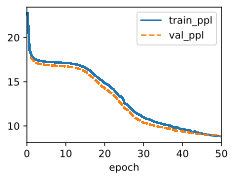

In [6]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
lstm = LSTMScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(lstm, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)